In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [13]:
import matplotlib.pyplot as plt
from utils.operators import ID, TopK, HOSVD, TuckerOp, TTSVD
from utils.train import run_training
from utils.graphs import plot_training_results

compression_operators = {
    'Id': (ID(), 1),
    'TopK': TopK(k=1000), # TODO в доле писать
    'Tucker': TuckerOp(),
    'TT_SVD': TTSVD(), # TODO фиксировать точность
    'HOSVD': HOSVD(), 
    # TODO округления
}



# for name, (op, num_epochs) in compression_operators.items():
#     run_training(
#         compression_op_name=name, 
#         compression_op=op, 
#         num_epochs=num_epochs,
#         # device='cuda'
#     )

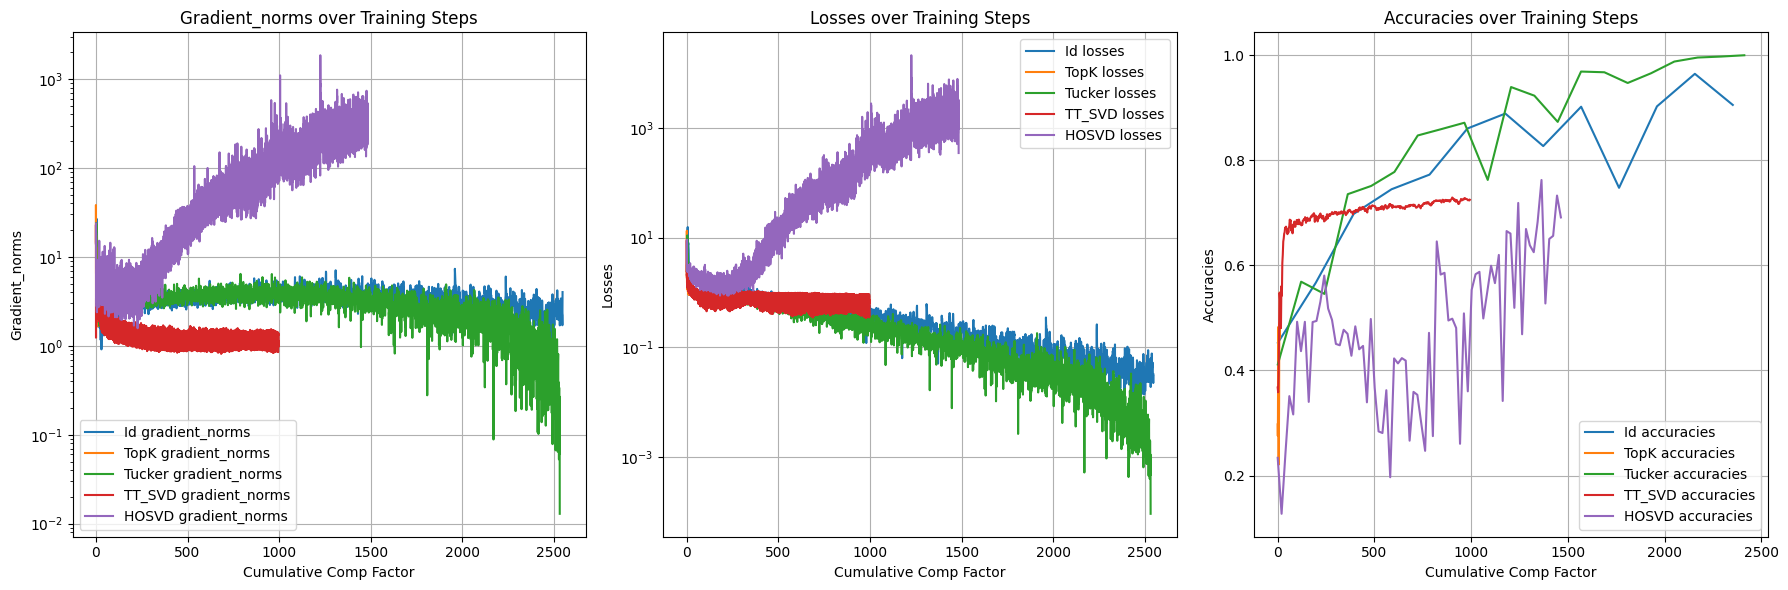

In [14]:
plot_training_results(compression_operators) # TODO скользящее среднее